In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Class_vogn import train_model_cc_fast,csvDataset,ToTensor
import torch.nn.functional as F
from active_function import *
from sklearn.model_selection import train_test_split
from vogn import VOGN

class EvalNet(nn.Module):

    def __init__(self, in_size=9, hidden=64, dropout_rate=None):
        super(EvalNet, self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.f1 = nn.Linear(in_size, hidden)
        self.f2 = nn.Linear(hidden,  hidden)
        self.f3 = nn.Linear(hidden,  7)

    def forward(self, x):
        out = x
        out = F.relu(self.f1(out))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.f2(out))
        if self.dropout:
            out = self.dropout(out)
        out = self.f3(out)
        return out  
    
class BaseNet(nn.Module):
    def __init__(self,dropout_rate=None):
        super(type(self), self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = nn.Linear(9, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 7)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        if self.dropout:
            out = self.dropout(out)
        x = F.relu(self.layer2(x))
        if self.dropout:
            out = self.dropout(out)
        out = self.layer3(x)
        return out

def random(x):
    a,b,c = x.shape
    return np.mean(np.std(x,axis=0),axis=0)

In [77]:
a = np.random.rand((10))

In [80]:
a

array([0.22263788, 0.95550478, 0.69869369, 0.15323678, 0.8359531 ,
       0.89478812, 0.76142054, 0.42290036, 0.27453064, 0.18361   ])

In [81]:
a[-2:]=a[-2:][::-1]

In [82]:
a

array([0.22263788, 0.95550478, 0.69869369, 0.15323678, 0.8359531 ,
       0.89478812, 0.76142054, 0.42290036, 0.18361   , 0.27453064])

In [71]:
df = pd.ExcelFile('Test Case 1 - OpAmp_280nm_GF55.xlsx').parse()

train = ['VDD','Ib','Lg1','Lg2','Lrf','Wcf','Wg1','Wg2','temperature']
target = ['ACM_G','SR','CMRR','NOISE','PSRR','PhaseMargin_PM','BandWidth']
X = df[train].values
Y = df[target].values


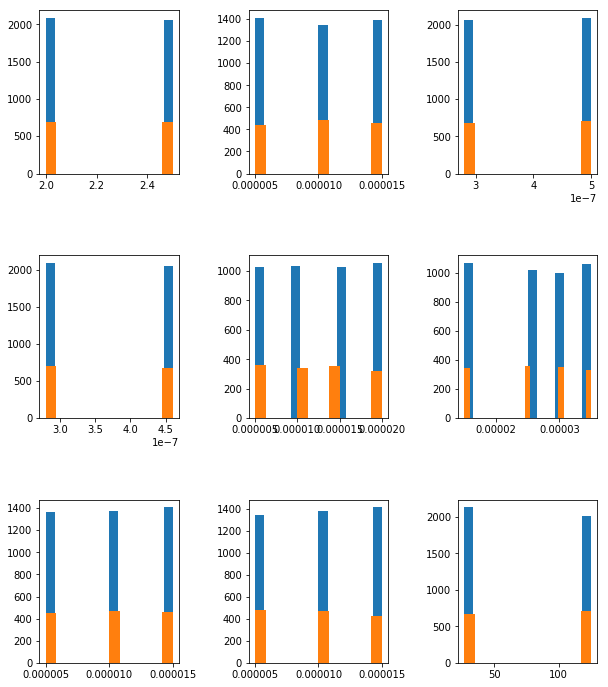

In [72]:
fig, axs = plt.subplots(3,3, figsize=(10, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.5, wspace=.5)

axs = axs.ravel()

trainX_tmp, Xtest, trainY_tmp, Ytest  = train_test_split(X, Y, test_size=0.2, random_state=1)
Xtrain, valX, Ytrain, valY = train_test_split(trainX_tmp, trainY_tmp, test_size=0.25, random_state=1)

for i in range(9):
    axs[i].hist(Xtrain[:,i], bins='auto')
    axs[i].hist(Xtest[:,i], bins='auto')

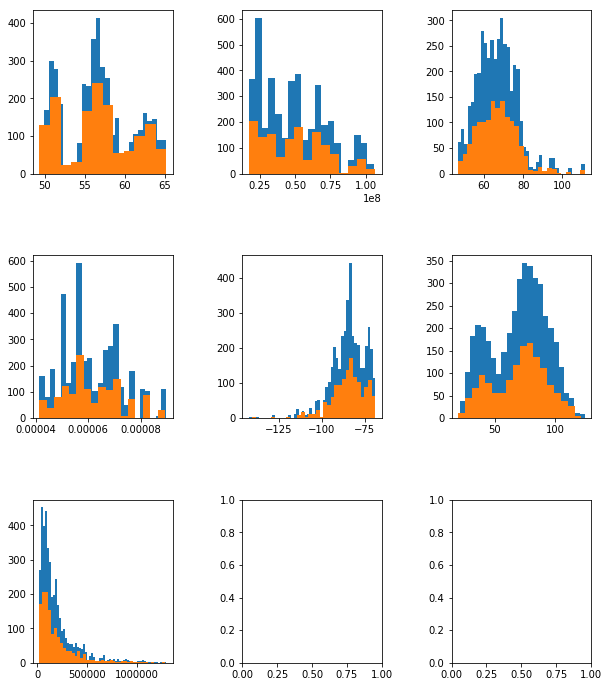

In [73]:
fig, axs = plt.subplots(3,3, figsize=(10, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.5, wspace=.5)

axs = axs.ravel()

axs = axs.ravel()

for i in range(7):
    axs[i].hist(Ytrain[:,i], bins='auto')
    axs[i].hist(Ytest[:,i], bins='auto')

In [57]:
for i in range(9):
    X[:,i]=(X[:,i] - X[:,i].mean())/(X[:,i].std())
for i in range(7):
    Y[:,i]=(Y[:,i] - Y[:,i].mean())/(Y[:,i].std())
    
trainX_tmp, Xtest, trainY_tmp, Ytest  = train_test_split(X, Y, test_size=0.2, random_state=1)
Xtrain, valX, Ytrain, valY = train_test_split(trainX_tmp, trainY_tmp, test_size=0.25, random_state=1)

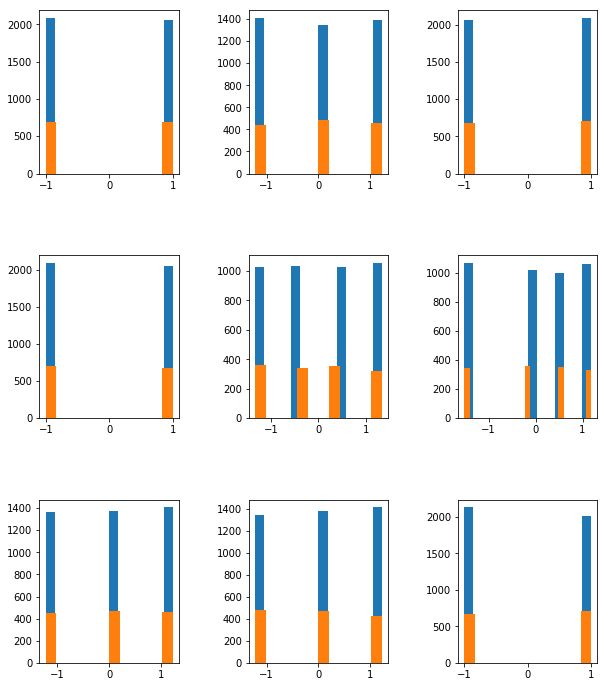

In [58]:
fig, axs = plt.subplots(3,3, figsize=(10, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.5, wspace=.5)

axs = axs.ravel()

axs = axs.ravel()

for i in range(9):
    axs[i].hist(Xtrain[:,i], bins='auto')
    axs[i].hist(Xtest[:,i], bins='auto')

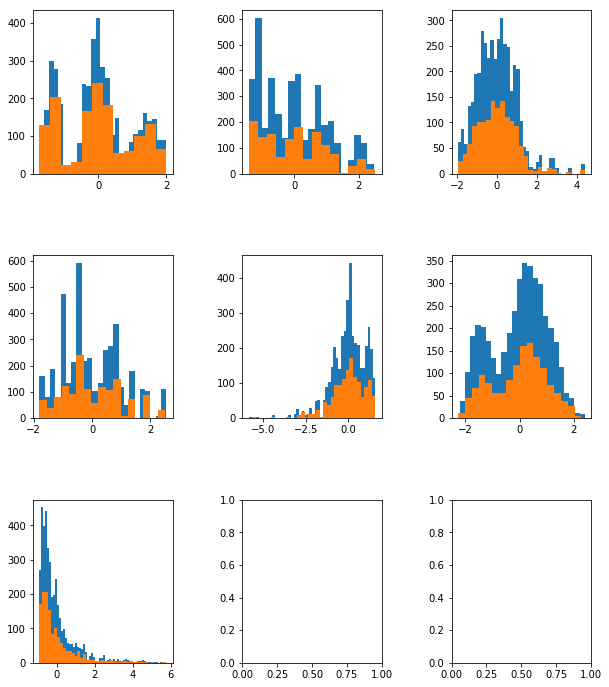

In [59]:
fig, axs = plt.subplots(3,3, figsize=(10, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =.5, wspace=.5)

axs = axs.ravel()

axs = axs.ravel()

for i in range(7):
    axs[i].hist(Ytrain[:,i], bins='auto')
    axs[i].hist(Ytest[:,i], bins='auto')

In [4]:
a = np.array([1,2,3,7,8,9,10])
a[-2:]
a[:(7-2):-1]

array([10])

In [5]:
X.shape,Xtest.shape,valX.shape

((6912, 9), (1383, 9), (1383, 9))

In [6]:
Ytrain.shape

(4146, 7)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)

In [8]:
pca.fit(Xtrain)
pca.explained_variance_ratio_

array([0.11663302, 0.11543351, 0.11426876, 0.11295651, 0.1112393 ,
       0.11011583, 0.10738743, 0.10683223, 0.10513341])

In [9]:
rez=np.zeros(100)
for x in range(2):
    a = np.random.choice(3420,20+30*x,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = EvalNet(dropout_rate=0.1)
    model = model.float().cuda()
    optimizer = optim.Adam(model.parameters(), weight_decay=0)
    criterion = F.mse_loss

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.mse_loss
    model, error,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep,error)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy())*1.
            labels = (labels.cpu().numpy())*1.

    rez[x]=np.sum((pred-labels)**2)/Xtest.shape[0]


49 0.00041492834522802646
49 0.0017727292859383212


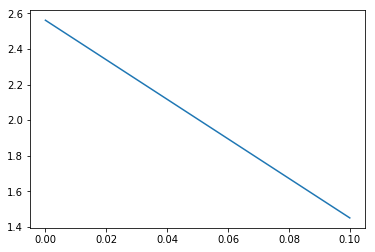

In [10]:
plt.plot(np.arange(2)/10,rez[:2])

___________________________

In [11]:
from optimizer_ import *

In [12]:
 inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=5, shuffle=False)

In [13]:
optimizer = Adam_grad_length(model)

9.64 64.64 64.7

In [14]:
for i in (inference_loader):
    inputs = i['data']
    labels = i['label']
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    def closure():
            optimizer.zero_grad()
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            return loss
    k,G2,A2 = optimizer.step(closure)
    print(len(ggn),ggn[0].cpu().numpy().shape)
    break        
            
            
            

TypeError: step() missing 1 required positional argument: 'size'

In [ ]:
k

for i in range(6):
    print(ggn[i].cpu().numpy().shape)

A2.shape,G2.shape

torch.einsum('ij, ik->jk', G2, A2).shape

A2.sum(1).shape,G2.sum(1).shape

A2.sum(1).mul(G2.sum(1)).shape

______________________

_____________

In [ ]:
for x, l in model.named_parameters() :
    print(x,l)

In [ ]:
optimizer = optim.Adam(model.parameters(), weight_decay=0,lr = 1)

In [ ]:

model.train(True)
for i in inference_loader:
    inputs = i['data']
    labels = i['label']
    inputs, labels = inputs.cuda(), labels.cuda()
    if isinstance(optimizer, VOGN):
        def closure():
            optimizer.zero_grad()
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            return loss
    else:
        def closure_():
            optimizer.zero_grad()
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            print('loss',loss)
            return loss
    break


In [ ]:
for x,l in model.named_parameters() :
    l.register_hook(lambda grad: print(grad))

In [ ]:
loss = optimizer.step(closure_)


In [ ]:
for x, l in model.named_parameters() :
    gradient, *_ = l.grad.data
    print(f"Gradient of {x} w.r.t to Loss: {gradient}")

In [ ]:
loss.backward()

In [ ]:
k = 0
for x, l in model.named_parameters() :
    gradient, *_ = l.grad.data
    k+=np.sum(np.abs(gradient.cpu().numpy()))
    print(f"Gradient of {x} w.r.t to Loss: {gradient}")
print('sum',k)

In [15]:
for x, l in model.named_parameters() :
    print(x,l)

f1.weight Parameter containing:
tensor([[ 0.0958, -0.3866, -0.2601, -0.1515,  0.2553,  0.3757, -0.0609, -0.2059,
          0.0541],
        [-0.2911,  0.2361, -0.2151, -0.0299,  0.2441, -0.3044,  0.3184, -0.1686,
         -0.0884],
        [ 0.1499, -0.2189, -0.1996, -0.3740, -0.3188, -0.2115,  0.3149, -0.2387,
         -0.1234],
        [ 0.0249,  0.0244,  0.3688, -0.0809,  0.1001, -0.0798, -0.3075, -0.2100,
          0.2685],
        [ 0.1361, -0.4408, -0.0725, -0.0227,  0.3458,  0.2425, -0.0008, -0.2132,
          0.3456],
        [ 0.1929,  0.4127,  0.1660,  0.4175, -0.1372, -0.0488, -0.0993,  0.3033,
          0.4389],
        [-0.0780, -0.0513,  0.5264, -0.2769,  0.2529,  0.3999,  0.0785, -0.1862,
         -0.0723],
        [ 0.2099, -0.2123,  0.0500, -0.4419, -0.0933, -0.1277,  0.0146,  0.3809,
          0.0798],
        [-0.0707, -0.0592,  0.3576,  0.2520, -0.1969, -0.3978,  0.1681,  0.2584,
          0.1781],
        [ 0.1644,  0.3132, -0.2165, -0.3703,  0.0524, -0.0434,  0.09

In [16]:
def random(x):
    a,b,c = x.shape
    return np.mean(np.std(x,axis=0),axis=0)

In [17]:
a = np.random.rand(100,10,15)
a.shape

(100, 10, 15)

In [18]:
random(a).shape

(15,)

In [19]:
b = a.transpose(0, 2, 1)
b.shape

(100, 15, 10)

In [20]:
np.sum(a,axis=(1,2)).shape

(100,)